In [45]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8, 3]
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels

import scipy
from scipy.stats import pearsonr

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [46]:
print(matplotlib.__version__)
print(pd.__version__)
print(np.__version__)
print(statsmodels.__version__)
print(scipy.__version__)


3.9.2
2.2.3
2.1.3
0.14.4
1.14.1


## Obtain and visualize data

In [47]:
## data obtained from https://datahub.io/core/global-temp#data
df = pd.read_csv("../datasets/global_temps.csv")
df.head()

,Source,Date,Mean
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504
3,GISTEMP,2016-11-06,0.9300
4,GCAG,2016-10-06,0.7292


<Axes: >

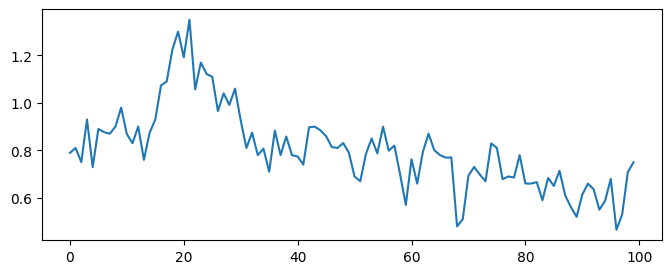

In [48]:
df.Mean[:100].plot()

## Exercise: what is wrong with the data and plot above? How can we fix this?

In [49]:
df = df.pivot(index='Date', columns='Source', values='Mean')

In [50]:
df.head()

Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18
1880-04-06,-0.0499,-0.27
1880-05-06,-0.0738,-0.14


<Axes: xlabel='Date'>

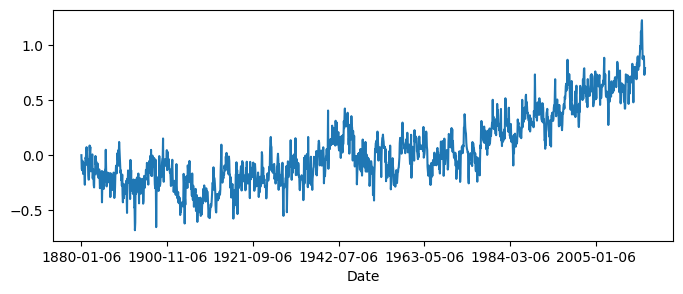

In [51]:
df.GCAG.plot()

In [52]:
type(df.index)

pandas.core.indexes.base.Index

## Exercise: how can we make the index more time aware?

In [53]:
df.index = pd.to_datetime(df.index)

In [54]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

<Axes: xlabel='Date'>

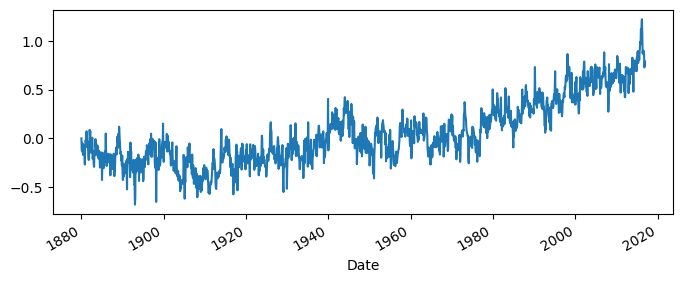

In [55]:
df.GCAG.plot()

In [56]:
df

Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18
1880-04-06,-0.0499,-0.27
1880-05-06,-0.0738,-0.14
...,...,...
2016-08-06,0.8998,0.98
2016-09-06,0.8767,0.87
2016-10-06,0.7292,0.89


In [57]:
df.loc['1880']

Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18
1880-04-06,-0.0499,-0.27
1880-05-06,-0.0738,-0.14
1880-06-06,-0.1692,-0.29
1880-07-06,-0.1491,-0.24
1880-08-06,-0.0725,-0.08
1880-09-06,-0.0817,-0.17


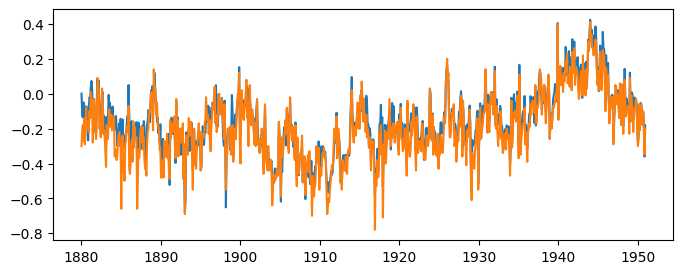

In [58]:
plt.plot(df['1880':'1950'][['GCAG', 'GISTEMP']])

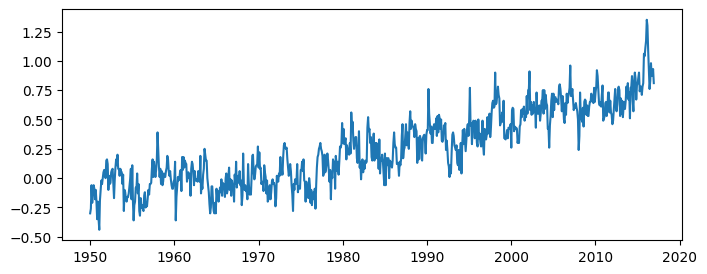

In [59]:
plt.plot(df['1950':][['GISTEMP']])

## Exercise: How strongly do these measurements correlate contemporaneously? What about with a time lag?

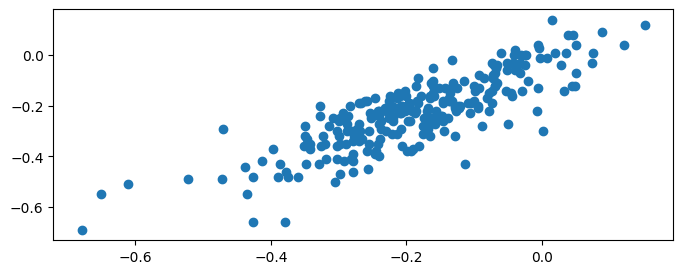

In [60]:
plt.scatter(df['1880':'1900'][['GCAG']], df['1880':'1900'][['GISTEMP']])

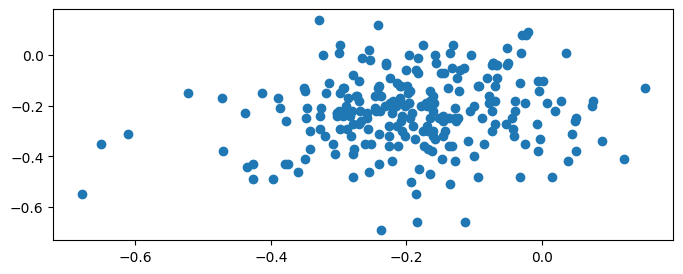

In [61]:
plt.scatter(df['1880':'1899'][['GCAG']], df['1881':'1900'][['GISTEMP']])

In [62]:
pearsonr(df['1880':'1899'].GCAG, df['1881':'1900'].GISTEMP)

PearsonRResult(statistic=np.float64(0.1546405732961276), pvalue=np.float64(0.016502234730950763))

In [63]:
df['1880':'1899'][['GCAG']].head()

Source,GCAG
Date,
1880-01-06,0.0009
1880-02-06,-0.1229
1880-03-06,-0.1357
1880-04-06,-0.0499
1880-05-06,-0.0738


In [64]:
df['1881':'1900'][['GISTEMP']].head()

Source,GISTEMP
Date,
1881-01-06,-0.10
1881-02-06,-0.14
1881-03-06,0.01
1881-04-06,-0.03
1881-05-06,-0.04


In [65]:
min(df.index)

Timestamp('1880-01-06 00:00:00')

In [66]:
max(df.index)

Timestamp('2016-12-06 00:00:00')

## Unobserved component model

In [67]:
train = df['1960':]

### model parameters

In [68]:
# smooth trend model without seasonal or cyclical components
model = {
    'level': 'smooth trend', 'cycle': False, 'seasonal': None, 
}


### fitting a model

In [89]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html
gcag_mod = sm.tsa.UnobservedComponents(train['GCAG'], **model)
gcag_res = gcag_mod.fit()

D:\My Files\All Scripts\TimeSeriesForecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


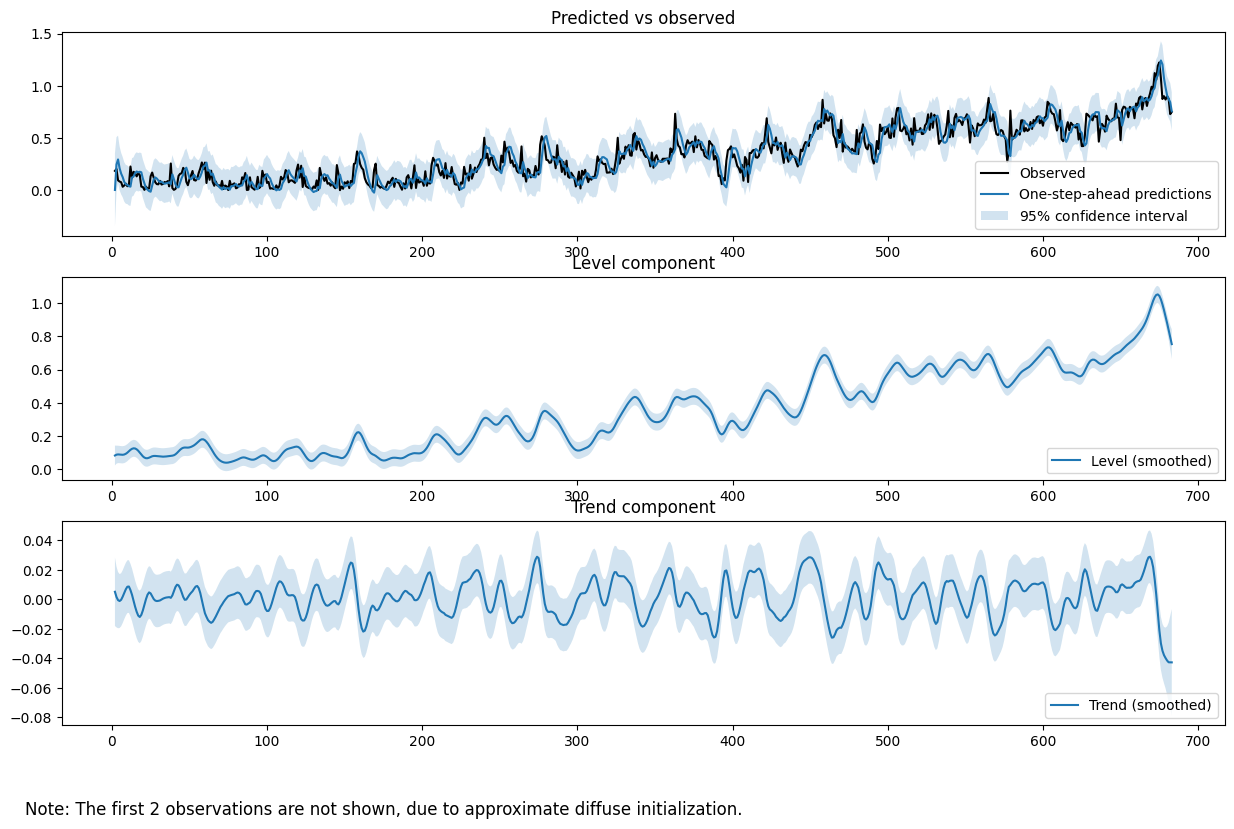

In [90]:
fig = gcag_res.plot_components(legend_loc='lower right', figsize=(15, 9));

## Plotting predictions

In [71]:
# Perform rolling prediction and multistep forecast
num_steps = 20
predict_res = gcag_res.get_prediction(dynamic=train['GCAG'].shape[0] - num_steps)

predict = predict_res.predicted_mean
ci = predict_res.conf_int()

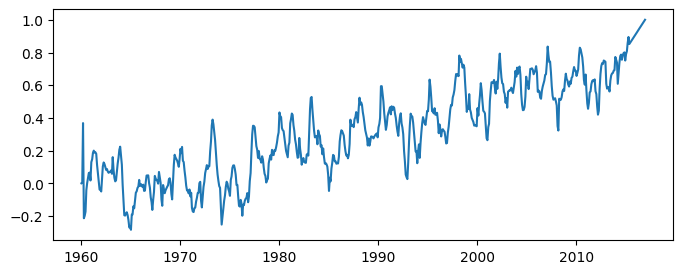

In [72]:
plt.plot(predict)

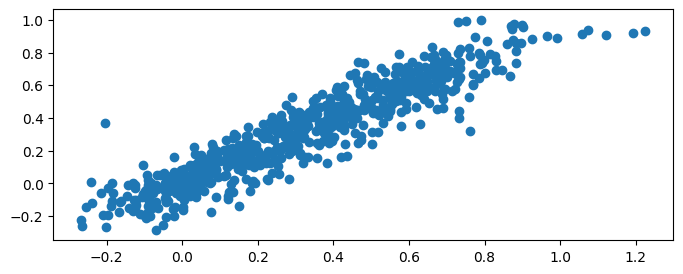

In [73]:
plt.scatter(train['GCAG'], predict)

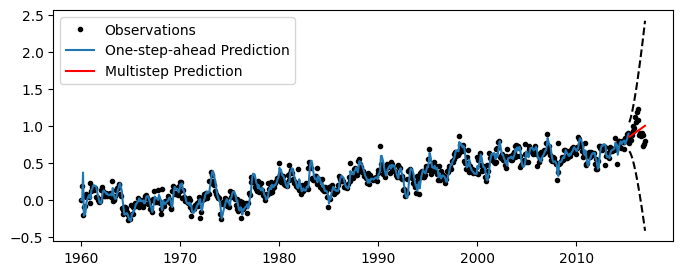

In [74]:
fig, ax = plt.subplots()
# Plot the results
ax.plot(train['GCAG'], 'k.', label='Observations')
ax.plot(train.index[:-num_steps], predict[:-num_steps], label='One-step-ahead Prediction')

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction')
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--')

# Cleanup the image
legend = ax.legend(loc='upper left')

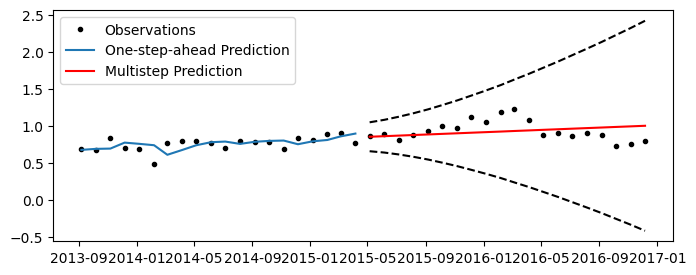

In [75]:
fig, ax = plt.subplots()
# Plot the results
ax.plot(train.index[-40:], train['GCAG'][-40:], 'k.', label='Observations')
ax.plot(train.index[-40:-num_steps], predict[-40:-num_steps], label='One-step-ahead Prediction')

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction')
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--')

# Cleanup the image
legend = ax.legend(loc='upper left')

## Exercise: consider adding a seasonal term for 12 periods for the model fit above. Does this improve the fit of the model?

In [76]:
seasonal_model = {
    'level': 'local linear trend',
    'seasonal': 12
}
mod = sm.tsa.UnobservedComponents(train['GCAG'], **seasonal_model)
res = mod.fit(method='powell', disp=False)

D:\My Files\All Scripts\TimeSeriesForecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


D:\My Files\All Scripts\TimeSeriesForecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


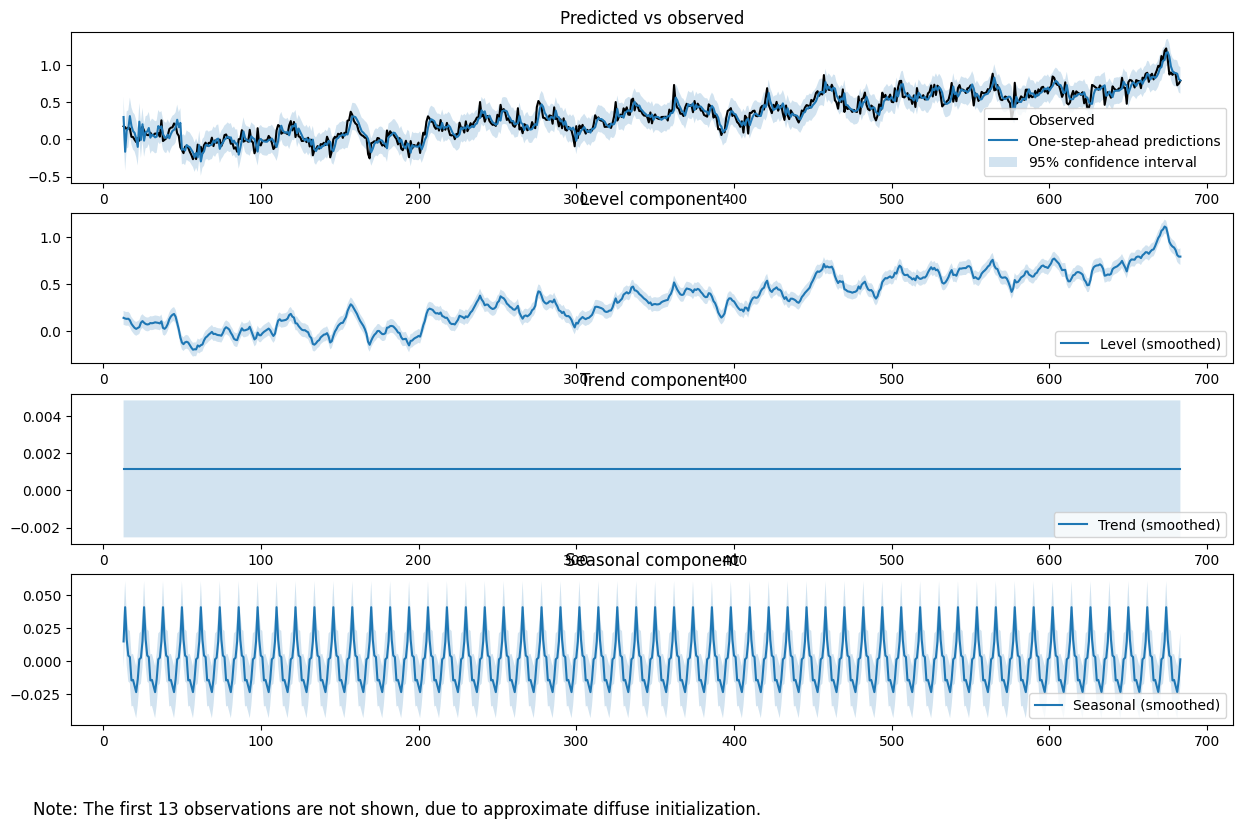

In [77]:
fig = res.plot_components(legend_loc='lower right', figsize=(15, 9));

## How does this compare to the original model?

In [78]:
pearsonr(gcag_res.predict(), train['GCAG'])

PearsonRResult(statistic=np.float64(0.9376554612284691), pvalue=np.float64(3.16463779e-315))

In [79]:
np.mean(np.abs(gcag_res.predict() - train['GCAG']))

np.float64(0.07721215662191556)

In [80]:
np.mean(np.abs(res.predict() - train['GCAG']))

np.float64(0.07203426252004273)

## Explore the seasonality more

In [81]:
seasonal_model = {
    'level': 'local level',
    'seasonal': 12
}
llmod = sm.tsa.UnobservedComponents(train['GCAG'], **seasonal_model)
ll_level_res = llmod.fit(method='powell', disp=False)

D:\My Files\All Scripts\TimeSeriesForecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


D:\My Files\All Scripts\TimeSeriesForecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


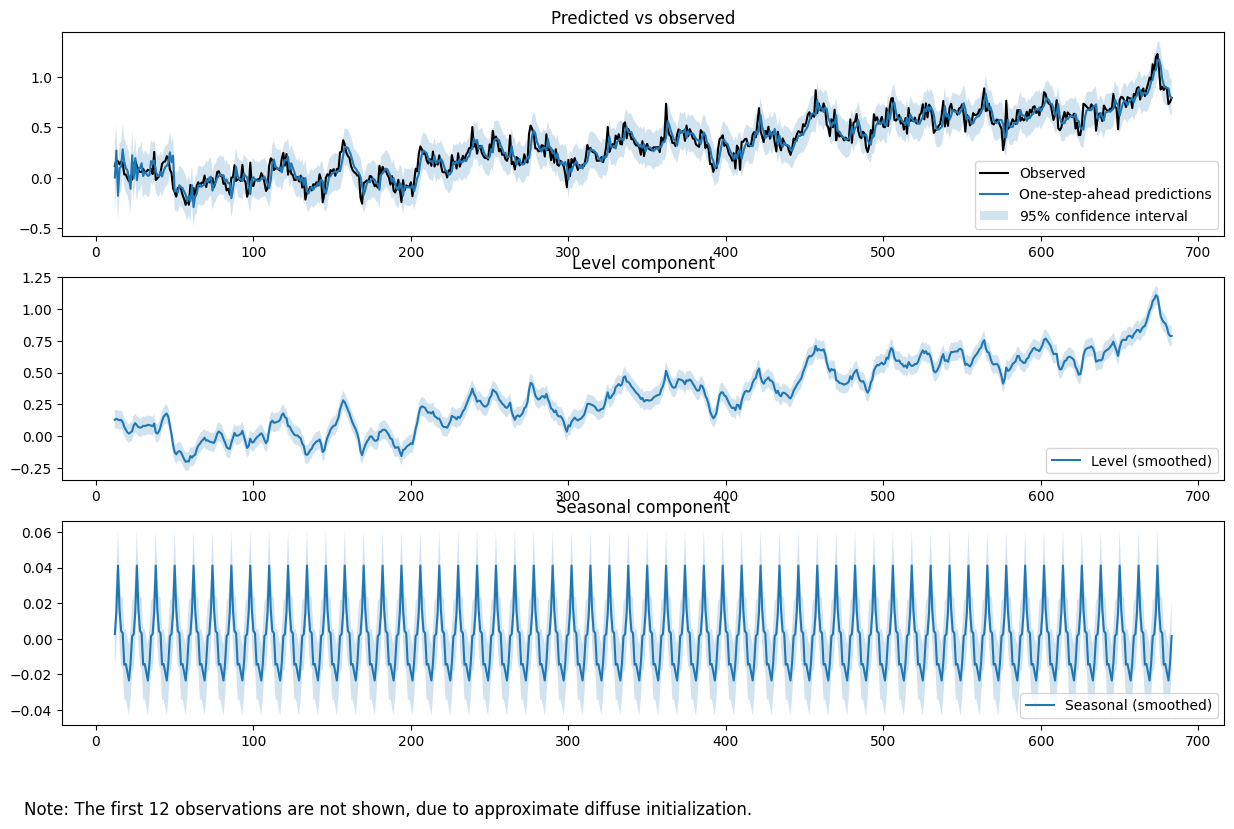

In [82]:
fig = ll_level_res.plot_components(legend_loc='lower right', figsize=(15, 9));

In [83]:
np.mean(np.abs(ll_level_res.predict() - train['GCAG']))

np.float64(0.07157760213054734)

<Axes: xlabel='Date'>

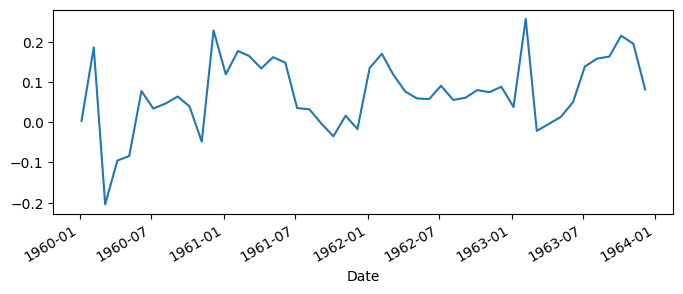

In [84]:
train[:48].GCAG.plot()

## Exercise: a common null model for time series is to predict the value at time t-1 for the value at time t. How does such a model compare to the models we fit here?

### Consider correlation

In [85]:
pearsonr(ll_level_res.predict(), train['GCAG'])

PearsonRResult(statistic=np.float64(0.9450047543118477), pvalue=np.float64(0.0))

In [86]:
pearsonr(train['GCAG'].iloc[:-1, ], train['GCAG'].iloc[1:, ])

PearsonRResult(statistic=np.float64(0.9403611903118241), pvalue=np.float64(4.01e-321))

### What about mean absolute error?

In [87]:
np.mean(np.abs(ll_level_res.predict() - train['GCAG']))

np.float64(0.07157760213054734)

In [88]:
np.mean(np.abs(train['GCAG'].iloc[:-1, ].values, train['GCAG'].iloc[1:, ].values))

np.float64(0.3475446559297218)